In [1]:
import json
import math
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import namedtuple, OrderedDict

In [2]:
INPUT_PATH = '../../input/pku-autonomous-driving'

In [3]:
ls $INPUT_PATH | head -n 10

camera_intrinsic.txt*
camera.zip*
car_models/
car_models_json/
car_models_json.zip*
car_models.zip*
Mesh_overlay/
sample_submission.csv*
split/
test_images/


In [4]:
Label = namedtuple('Label', [
    'name'        , # The name of a car type
    'id'          , # id for specific car type
    'category'    , # The name of the car category, 'SUV', 'Sedan' etc
    'categoryId'  , # The ID of car category. Used to create ground truth images
                    # on category level.
])

models = [
    #     name          id   is_valid  category  categoryId
    Label(             'baojun-310-2017',          0,       '2x',          0),
    Label(                'biaozhi-3008',          1,       '2x',          0),
    Label(          'biaozhi-liangxiang',          2,       '2x',          0),
    Label(           'bieke-yinglang-XT',          3,       '2x',          0),
    Label(                'biyadi-2x-F0',          4,       '2x',          0),
    Label(               'changanbenben',          5,       '2x',          0),
    Label(                'dongfeng-DS5',          6,       '2x',          0),
    Label(                     'feiyate',          7,       '2x',          0),
    Label(         'fengtian-liangxiang',          8,       '2x',          0),
    Label(                'fengtian-MPV',          9,       '2x',          0),
    Label(           'jilixiongmao-2015',         10,       '2x',          0),
    Label(           'lingmu-aotuo-2009',         11,       '2x',          0),
    Label(                'lingmu-swift',         12,       '2x',          0),
    Label(             'lingmu-SX4-2012',         13,       '2x',          0),
    Label(              'sikeda-jingrui',         14,       '2x',          0),
    Label(        'fengtian-weichi-2006',         15,       '3x',          1),
    Label(                   '037-CAR02',         16,       '3x',          1),
    Label(                     'aodi-a6',         17,       '3x',          1),
    Label(                   'baoma-330',         18,       '3x',          1),
    Label(                   'baoma-530',         19,       '3x',          1),
    Label(            'baoshijie-paoche',         20,       '3x',          1),
    Label(             'bentian-fengfan',         21,       '3x',          1),
    Label(                 'biaozhi-408',         22,       '3x',          1),
    Label(                 'biaozhi-508',         23,       '3x',          1),
    Label(                'bieke-kaiyue',         24,       '3x',          1),
    Label(                        'fute',         25,       '3x',          1),
    Label(                     'haima-3',         26,       '3x',          1),
    Label(               'kaidilake-CTS',         27,       '3x',          1),
    Label(                   'leikesasi',         28,       '3x',          1),
    Label(               'mazida-6-2015',         29,       '3x',          1),
    Label(                  'MG-GT-2015',         30,       '3x',          1),
    Label(                       'oubao',         31,       '3x',          1),
    Label(                        'qiya',         32,       '3x',          1),
    Label(                 'rongwei-750',         33,       '3x',          1),
    Label(                  'supai-2016',         34,       '3x',          1),
    Label(             'xiandai-suonata',         35,       '3x',          1),
    Label(            'yiqi-benteng-b50',         36,       '3x',          1),
    Label(                       'bieke',         37,       '3x',          1),
    Label(                   'biyadi-F3',         38,       '3x',          1),
    Label(                  'biyadi-qin',         39,       '3x',          1),
    Label(                     'dazhong',         40,       '3x',          1),
    Label(              'dazhongmaiteng',         41,       '3x',          1),
    Label(                    'dihao-EV',         42,       '3x',          1),
    Label(      'dongfeng-xuetielong-C6',         43,       '3x',          1),
    Label(     'dongnan-V3-lingyue-2011',         44,       '3x',          1),
    Label(    'dongfeng-yulong-naruijie',         45,      'SUV',          2),
    Label(                     '019-SUV',         46,      'SUV',          2),
    Label(                   '036-CAR01',         47,      'SUV',          2),
    Label(                 'aodi-Q7-SUV',         48,      'SUV',          2),
    Label(                  'baojun-510',         49,      'SUV',          2),
    Label(                    'baoma-X5',         50,      'SUV',          2),
    Label(             'baoshijie-kayan',         51,      'SUV',          2),
    Label(             'beiqi-huansu-H3',         52,      'SUV',          2),
    Label(              'benchi-GLK-300',         53,      'SUV',          2),
    Label(                'benchi-ML500',         54,      'SUV',          2),
    Label(         'fengtian-puladuo-06',         55,      'SUV',          2),
    Label(            'fengtian-SUV-gai',         56,      'SUV',          2),
    Label(    'guangqi-chuanqi-GS4-2015',         57,      'SUV',          2),
    Label(        'jianghuai-ruifeng-S3',         58,      'SUV',          2),
    Label(                  'jili-boyue',         59,      'SUV',          2),
    Label(                      'jipu-3',         60,      'SUV',          2),
    Label(                  'linken-SUV',         61,      'SUV',          2),
    Label(                   'lufeng-X8',         62,      'SUV',          2),
    Label(                 'qirui-ruihu',         63,      'SUV',          2),
    Label(                 'rongwei-RX5',         64,      'SUV',          2),
    Label(             'sanling-oulande',         65,      'SUV',          2),
    Label(                  'sikeda-SUV',         66,      'SUV',          2),
    Label(            'Skoda_Fabia-2011',         67,      'SUV',          2),
    Label(            'xiandai-i25-2016',         68,      'SUV',          2),
    Label(            'yingfeinidi-qx80',         69,      'SUV',          2),
    Label(             'yingfeinidi-SUV',         70,      'SUV',          2),
    Label(                  'benchi-SUR',         71,      'SUV',          2),
    Label(                 'biyadi-tang',         72,      'SUV',          2),
    Label(           'changan-CS35-2012',         73,      'SUV',          2),
    Label(                 'changan-cs5',         74,      'SUV',          2),
    Label(          'changcheng-H6-2016',         75,      'SUV',          2),
    Label(                 'dazhong-SUV',         76,      'SUV',          2),
    Label(     'dongfeng-fengguang-S560',         77,      'SUV',          2),
    Label(       'dongfeng-fengxing-SX6',         78,      'SUV',          2)
]

car_name2id = {label.name: label for label in models}
car_id2name = {label.id: label for label in models}

In [5]:
MODEL_DIR = os.path.join(INPUT_PATH, 'car_models_json')

def load_car_models(model_dir=MODEL_DIR):
    """Load all the car models
    """
    car_models_all = OrderedDict([])
    print('loading %d car models' % len(models))
    for model in models:
        car_model = '%s/%s.json' % (model_dir, model.name)
        with open(car_model) as json_file:
            car = json.load(json_file)
        for key in ['vertices', 'faces']:
            car[key] = np.array(car[key])
        # fix the inconsistency between obj and pkl
        car['vertices'][:, [0, 1]] *= -1
        car_models_all[model.name] = car 
    return car_models_all  

In [6]:
def imread(path, img_dir=INPUT_PATH):
    path = os.path.join(img_dir, path)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image


def imshow(img, boxes=None, figsize=(15,8)):
    plt.figure(figsize=figsize)
    if boxes is not None:
        for bbox in boxes:
            rect = plt.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1], fill=False,
                edgecolor='g', linewidth=1)
            plt.gca().add_patch(rect)
    plt.imshow(img);

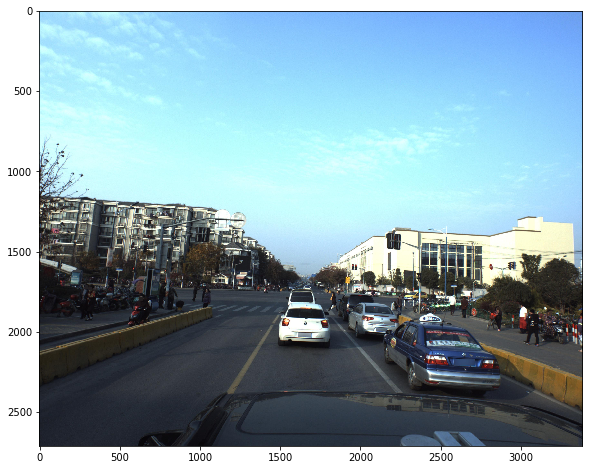

In [7]:
img = imread('train_images/ID_003c35b2e.jpg')
imshow(img)

In [8]:
height, width = img.shape[0], img.shape[1]
c = np.array([img.shape[1] / 2., img.shape[0] / 2.])
s = np.array([width, height], dtype=np.int32)

In [9]:
width, height, c, s

(3384, 2710, array([1692., 1355.]), array([3384, 2710], dtype=int32))

In [10]:
def rand_affine(c, s, cf=0.1, sf=0.4):
    s = s * np.clip(np.random.randn()*sf + 1, 1 - sf, 1 + sf)
    c[0] += img.shape[1] * np.clip(np.random.randn()*cf, -2*cf, 2*cf)
    c[1] += img.shape[0] * np.clip(np.random.randn()*cf, -2*cf, 2*cf)
    return c, s

In [11]:
def get_dir(src_point, rot_rad):
    sn, cs = np.sin(rot_rad), np.cos(rot_rad)
    src_result = [0, 0]
    src_result[0] = src_point[0] * cs - src_point[1] * sn
    src_result[1] = src_point[0] * sn + src_point[1] * cs
    return src_result


def get_3rd_point(a, b):
    direct = a - b
    return b + np.array([-direct[1], direct[0]], dtype=np.float32)


def get_affine_transform(center, scale, rot, output_size,
                         shift=np.array([0, 0], dtype=np.float32),
                         inv=0):
    if not isinstance(scale, np.ndarray) and not isinstance(scale, list):
        scale = np.array([scale, scale], dtype=np.float32)

    scale_tmp = scale
    src_w = scale_tmp[0]
    dst_w = output_size[0]
    dst_h = output_size[1]

    rot_rad = np.pi * rot / 180
    src_dir = get_dir([0, src_w * -0.5], rot_rad)
    dst_dir = np.array([0, dst_w * -0.5], np.float32)

    src = np.zeros((3, 2), dtype=np.float32)
    dst = np.zeros((3, 2), dtype=np.float32)
    src[0, :] = center + scale_tmp * shift
    src[1, :] = center + src_dir + scale_tmp * shift
    dst[0, :] = [dst_w * 0.5, dst_h * 0.5]
    dst[1, :] = np.array([dst_w * 0.5, dst_h * 0.5], np.float32) + dst_dir

    src[2:, :] = get_3rd_point(src[0, :], src[1, :])
    dst[2:, :] = get_3rd_point(dst[0, :], dst[1, :])

    if inv:
        trans = cv2.getAffineTransform(np.float32(dst), np.float32(src))
    else:
        trans = cv2.getAffineTransform(np.float32(src), np.float32(dst))

    return trans

In [12]:
trans_input = get_affine_transform(c, s, 0, [width, height])
trans_input

array([[ 1.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 3.35954012e-17,  1.00000000e+00, -5.68434189e-14]])

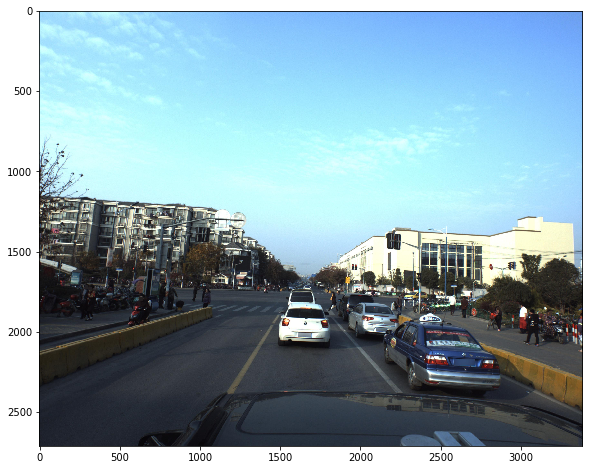

In [13]:
inp = cv2.warpAffine(img, trans_input, (width, height), flags=cv2.INTER_LINEAR)
imshow(inp)

In [14]:
def find_car_poses(df, img_id):
    cars = df.loc[df['ImageId'] == img_id, 'PredictionString'].values[0]
    return str2np(str(cars))


def str2np(s):
    cars = np.array(s.split()).reshape([-1,7])
    out = []
    for car in cars:
        car = {'car_id': int(car[0]), 'pose': car[1:].astype(np.float64)}
        out.append(car)
    return out

In [15]:
def gaussian_radius(det_size, min_overlap=0.7):
    height, width = det_size

    a1  = 1
    b1  = (height + width)
    c1  = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1  = (b1 + sq1) / 2

    a2  = 4
    b2  = 2 * (height + width)
    c2  = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2  = (b2 + sq2) / 2

    a3  = 4 * min_overlap
    b3  = -2 * min_overlap * (height + width)
    c3  = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3  = (b3 + sq3) / 2
    return min(r1, r2, r3)


def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def draw_umich_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap


def affine_transform(pt, t):
    new_pt = np.array([pt[0], pt[1], 1.], dtype=np.float32).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2]

In [16]:
camera_matrix = np.array([
    [2304.5479,    0     , 1686.2379],
    [   0     , 2305.8757, 1354.9849],
    [   0     ,    0     ,    1     ]
], dtype=np.float32)


def euler_angles_to_rotation_matrix(angle, is_dir=False):
    """Convert euler angels to quaternions.
    Input:
        angle: [roll, pitch, yaw]
        is_dir: whether just use the 2d direction on a map
    """
    yaw, pitch, roll = -angle[0], -angle[1], -angle[2]
    Rx = np.array([
        [1, 0, 0],
        [0, math.cos(yaw), -math.sin(yaw)],
        [0, math.sin(yaw), math.cos(yaw)]
    ])
    Ry = np.array([
        [math.cos(pitch), 0, math.sin(pitch)],
        [0, 1, 0],
        [-math.sin(pitch), 0, math.cos(pitch)]
    ])
    Rz = np.array([
        [math.cos(roll), -math.sin(roll), 0],
        [math.sin(roll), math.cos(roll), 0],
        [0, 0, 1]
    ])
    R = Ry @ Rx @ Rz
    if is_dir:
        R = R[:, 2]
    return R


def calc_2D_boxes(car_poses, car_models, image_shape, im_scale=1.0):
    """Add ground truth annotation metadata to an roidb entry."""
    # initiate the lists
    boxes = []
    for i, car_pose in enumerate(car_poses):
        car_name = car_id2name[car_pose['car_id']].name
        car = car_models[car_name]
        pose = np.array(car_pose['pose'])
        
        # project 3D points to 2d image plane
        rot_mat = euler_angles_to_rotation_matrix(pose[:3])
        rvect, _ = cv2.Rodrigues(rot_mat)
        imgpts, jac = cv2.projectPoints(np.float32(car['vertices']), rvect, pose[3:], camera_matrix, distCoeffs=None)
        imgpts = np.int32(imgpts).reshape(-1, 2)
        
        x1, y1, x2, y2 = imgpts[:, 0].min(), imgpts[:, 1].min(), imgpts[:, 0].max(), imgpts[:, 1].max()
        boxes.append([x1, y1, x2, y2])
    return boxes

In [17]:
car_models = load_car_models()

loading 79 car models


In [18]:
df = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'))

In [20]:
num_classes = 1
max_objs = 50

anns = find_car_poses(df, 'ID_003c35b2e')
bboxs = calc_2D_boxes(anns, car_models, s)

for ann, bbox in zip(anns, calc_2D_boxes(anns, car_models, s)):
    ann['bbox'] = np.array(bbox)

num_objs = min(len(anns), max_objs)
num_objs

6

In [21]:
anns[0]

{'car_id': 40,
 'pose': array([ 0.10454 ,  0.041497, -3.08319 , -0.26201 ,  3.67187 , 14.9901  ]),
 'bbox': array([1484, 1807, 1808, 2080], dtype=int32)}

In [22]:
down_ratio = 4
out_w, out_h = width // down_ratio, height // down_ratio
out_w, out_h

(846, 677)

In [23]:
draw_gaussian = draw_umich_gaussian
aug = False

hm = np.zeros((num_classes, out_h, out_w), dtype=np.float32)
# wh = np.zeros((max_objs, 2), dtype=np.float32)
# reg = np.zeros((max_objs, 2), dtype=np.float32)
# dep = np.zeros((max_objs, 1), dtype=np.float32)
# rotbin = np.zeros((max_objs, 2), dtype=np.int64)
# rotres = np.zeros((max_objs, 2), dtype=np.float32)
# dim = np.zeros((max_objs, 3), dtype=np.float32) # dimensions ?
# ind = np.zeros((max_objs), dtype=np.int64)
# reg_mask = np.zeros((max_objs), dtype=np.uint8)
# rot_mask = np.zeros((max_objs), dtype=np.uint8)

trans_output = get_affine_transform(c, s, 0, [out_w, out_h])

for k in range(num_objs):
    ann = anns[k]
    bbox = ann['bbox']
    # if flipped:
    #   bbox[[0, 2]] = width - bbox[[2, 0]] - 1
    bbox[:2] = affine_transform(bbox[:2], trans_output)
    bbox[2:] = affine_transform(bbox[2:], trans_output)
    bbox[[0, 2]] = np.clip(bbox[[0, 2]], 0, out_w - 1)
    bbox[[1, 3]] = np.clip(bbox[[1, 3]], 0, out_h - 1)
    h, w = bbox[3] - bbox[1], bbox[2] - bbox[0]
    if h > 0 and w > 0:
        radius = gaussian_radius((h, w))
        radius = max(0, int(radius))
        ct = np.array(
          [(bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2], dtype=np.float32)
        ct_int = ct.astype(np.int32)
        draw_gaussian(hm[0], ct, radius)

#         wh[k] = 1. * w, 1. * h
#         gt_det.append([ct[0], ct[1], 1] + \
#                       self._alpha_to_8(self._convert_alpha(ann['alpha'])) + \
#                       [ann['depth']] + (np.array(ann['dim']) / 1).tolist() + [cls_id])
#         if self.opt.reg_bbox:
#           gt_det[-1] = gt_det[-1][:-1] + [w, h] + [gt_det[-1][-1]]
#         # if (not self.opt.car_only) or cls_id == 1: # Only estimate ADD for cars !!!
#         if 1:
#             alpha = self._convert_alpha(ann['alpha'])
#             # print('img_id cls_id alpha rot_y', img_path, cls_id, alpha, ann['rotation_y'])
#             if alpha < np.pi / 6. or alpha > 5 * np.pi / 6.:
#                 rotbin[k, 0] = 1
#                 rotres[k, 0] = alpha - (-0.5 * np.pi)    
#             if alpha > -np.pi / 6. or alpha < -5 * np.pi / 6.:
#                 rotbin[k, 1] = 1
#                 rotres[k, 1] = alpha - (0.5 * np.pi)
#             dep[k] = ann['depth']
#             dim[k] = ann['dim']
#             ind[k] = ct_int[1] * self.opt.output_w + ct_int[0]
#             reg[k] = ct - ct_int
#             reg_mask[k] = 1 if not aug else 0
#             rot_mask[k] = 1

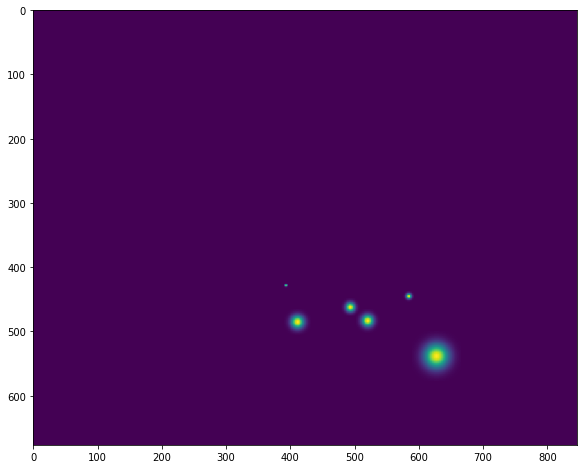

In [24]:
imshow(hm.squeeze(0))

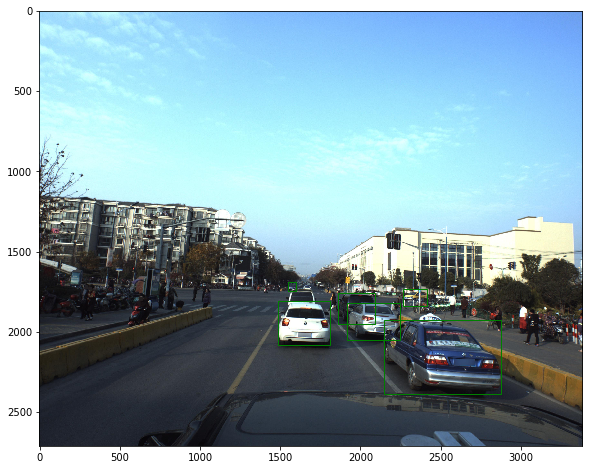

In [25]:
bboxs = calc_2D_boxes(anns, car_models, s)
imshow(img, boxes=bboxs)